### Pedalcast: Predicting daily bike usage for each station - Modeling & Feature Engineering Notebook

#### Imports

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import shap
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

In [35]:
daily_counts = pd.read_csv('data/daily_counts_with_weather.csv')
daily_counts['date'] = pd.to_datetime(daily_counts['date'])

### Feature Engineering: `create_features(df)`

This function generates key features to support station-level bike demand forecasting. It takes a DataFrame with daily trip counts and returns a new DataFrame with additional time-based and lag features, including:

- **Calendar Features**:  
  `dayofweek`, `is_weekend`, `month`, `quarter`, `year`, `dayofyear`, `dayofmonth`, and `weekofyear`  
  These capture patterns related to the day, seasonality, and temporal cycles.

- **Season Label**:  
  A simplified `season` column is derived from the month and one-hot encoded.

- **Lag Features** (per station):  
  - `lag_1`: Trip count from the previous day  
  - `lag_7`: Trip count from the same day the previous week  
  - `rolling_7`: 7-day rolling average of trip count (excluding the current day)  

These features allow the model to learn from both recent usage trends and structured temporal patterns.

In [36]:
def create_features(df):
    out = df.copy()
    # Monday(0) - Sunday (6)
    out['dayofweek'] = out['date'].dt.dayofweek
    out['is_weekend'] = out['dayofweek'] >= 5
    out['quarter'] = out['date'].dt.quarter 
    out['year'] = out['date'].dt.year 
    out['month'] = out['date'].dt.month 
    out['dayofyear'] = out['date'].dt.dayofyear 
    out['dayofmonth'] = out['date'].dt.day 
    out['weekofyear'] = out['date'].dt.isocalendar().week 
   
    def assign_season(month):
        if month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        elif month in [9, 10, 11]:
            return 'Fall'
        else:
            return 'Winter'

    out['season'] = out['month'].apply(assign_season)
    
    out = out.sort_values(['start_station_id', 'date'])

    out['lag_1'] = out.groupby('start_station_id')['trip_count'].shift(1)

    out['lag_7'] = out.groupby('start_station_id')['trip_count'].shift(7)
    
    out['rolling_7'] = (
        out.groupby('start_station_id')['trip_count']
           .shift(1)  # Exclude today
           .rolling(window=7)
           .mean()
           .reset_index(level=0, drop=True)
    )

    # One-hot encode season
    out = pd.get_dummies(out, columns=['season'])

    
    return out

In [37]:
daily_counts_wft = create_features(daily_counts)
daily_counts_wft.head()

,start_station_id,start_station_name,date,trip_count,temp,humidity,precip,snow,windspeed,visibility,...,dayofyear,dayofmonth,weekofyear,lag_1,lag_7,rolling_7,season_Fall,season_Spring,season_Summer,season_Winter
0,A32000,Fan Pier,2023-07-01,30,19.3,93.5,0.000,0.0,20.3,4.8,...,182,1,26,NaN,NaN,NaN,False,False,True,False
1,A32000,Fan Pier,2023-07-02,20,20.9,89.9,8.278,0.0,28.9,7.6,...,183,2,26,30.0,NaN,NaN,False,False,True,False
2,A32000,Fan Pier,2023-07-03,28,20.4,89.4,14.249,0.0,18.0,10.4,...,184,3,27,20.0,NaN,NaN,False,False,True,False
3,A32000,Fan Pier,2023-07-04,35,20.1,94.4,12.163,0.0,16.4,12.0,...,185,4,27,28.0,NaN,NaN,False,False,True,False
4,A32000,Fan Pier,2023-07-05,41,23.9,78.4,0.000,0.0,17.8,13.3,...,186,5,27,35.0,NaN,NaN,False,False,True,False


### Drop Rows with Missing Lag Features

Lag features like `lag_1`, `lag_7`, and `rolling_7` require prior data to be computed. As a result, the earliest days for each station (where lag values are undefined) contain missing values.
So, we drop them to ensure all training data has complete feature sets, which also preserves model quality by removing rows that lack historical context.

In [38]:
# drop some rows for lags
daily_counts_wft.isna().sum()[daily_counts_wft.isna().sum()!=0]

lag_1         554
lag_7        3877
rolling_7    3877
dtype: int64

In [39]:
# drop values with missing lags
daily_counts_wft = daily_counts_wft.dropna(subset=['lag_1', 'lag_7', 'rolling_7'])


#### Train/Test Split for Forecasting

We separate the dataset into features (`X`) and target (`y`), where `trip_count` is the value we want to predict.

Then, we split the data into:

- **Training data** includes all dates **before June 2025**
- **Test data** includes dates in **June 2025**, which we will use to evaluate model performance on unseen future data

Later, we’ll use **TimeSeriesSplit** for cross-validation on the training data during hyperparameter tuning, to ensure the model is validated on temporally consistent folds.

In [40]:
X = daily_counts_wft.drop(['trip_count'],axis=1,errors='ignore')
y = daily_counts_wft['trip_count']

In [41]:

X_train = X[X['date'] < '2025-06-01']
X_test = X[X['date'] >= '2025-06-01']
y_train = y.loc[X_train.index]
y_test = y.loc[X_test.index]

#### Encode Station IDs for Modeling

Since `start_station_id` is a string, we use `LabelEncoder` to convert it into a numeric format suitable for XGBoost.

Steps:
1. Fit the encoder on the training set station IDs.
2. Filter the test set to include only stations that were seen in the training set (to avoid unseen label errors).
3. Align `y_test` with the filtered `X_test` so their indices match.
4. Apply the encoder to transform station IDs in the test set.

In [42]:

le = LabelEncoder()
X_train['station_id_encoded'] = le.fit_transform(X_train['start_station_id'])

X_test = X_test[X_test['start_station_id'].isin(X_train['start_station_id'])]

y_test = y_test.loc[X_test.index]

X_test['station_id_encoded'] = le.transform(X_test['start_station_id'])

/var/folders/cl/4ndfg5191d74xd8pclttf16w0000gn/T/ipykernel_92491/1971267989.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['station_id_encoded'] = le.fit_transform(X_train['start_station_id'])


We drop columns like `start_station_name`, `start_station_id`, and `date` since they are either non-numeric and redundant (already encoded). We needed them before to do certain operations like in the previous cell.

In [43]:
drop_cols = ['start_station_name', 'date','start_station_id']
X_train = X_train.drop(columns=drop_cols, errors='ignore')
X_test = X_test.drop(columns=drop_cols, errors='ignore')

#### Hyperparameter Tuning with GridSearchCV

We perform a grid search over a predefined set of XGBoost hyperparameters to find the combination that minimizes RMSE.

- **Parameters tuned**: `max_depth`, `learning_rate`, `n_estimators`, `subsample`, and `colsample_bytree`
- **Cross-validation**: `TimeSeriesSplit` ensures temporally consistent folds
- **Scoring**: Negative RMSE is used as the optimization metric

The best model configuration is selected based on cross-validated RMSE.

**Note**: Other parameter combinations were also tested, but this setup consistently produced the best performance.

In [51]:
param_grid = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.05, 0.1],
    "n_estimators": [100, 300],
    "subsample": [0.8],
    "colsample_bytree": [0.8],
}

model = XGBRegressor(random_state=42)

tscv = TimeSeriesSplit(n_splits=5)

xgb_grid_search = GridSearchCV(
    model,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",  # for RMSE
    cv=tscv,
    verbose=2,
    n_jobs=-1
)

xgb_grid_search.fit(X_train, y_train)

print(f"Best RMSE: {-grid_search.best_score_:.2f}")
print("Best params:", grid_search.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=300, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.4s
[CV] END co

#### Final Model Evaluation on Test Set

We use the best model from `GridSearchCV` to predict bike demand on the June 2025 test set.

- **RMSE (Root Mean Squared Error)** measures the average prediction error in trip counts.
- **R² Score** indicates how much variance in the target is explained by the model.

These metrics give a final assessment of how well the model generalizes to unseen future data.

In [53]:
y_pred = xgb_grid_search.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Test RMSE: {rmse:.2f}")

r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.4f}")

Test RMSE: 9.74
R² Score: 0.9152


/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


#### Most Important Features for the Model

We use two methods to evaluate feature importance:

1. **XGBoost’s Built-in Feature Importances**  
   - `feature_importances_` returns the relative importance of each feature based on how much it contributes to reducing error (gain) across all trees.
   - A horizontal bar plot visualizes which features the model relied on most globally.

2. **SHAP (SHapley Additive exPlanations)**  
   - `TreeExplainer` is used to calculate SHAP values for each feature and each prediction.
   - The SHAP summary plot (`dot` plot) shows both the **magnitude** and **direction** of each feature’s impact across the dataset.

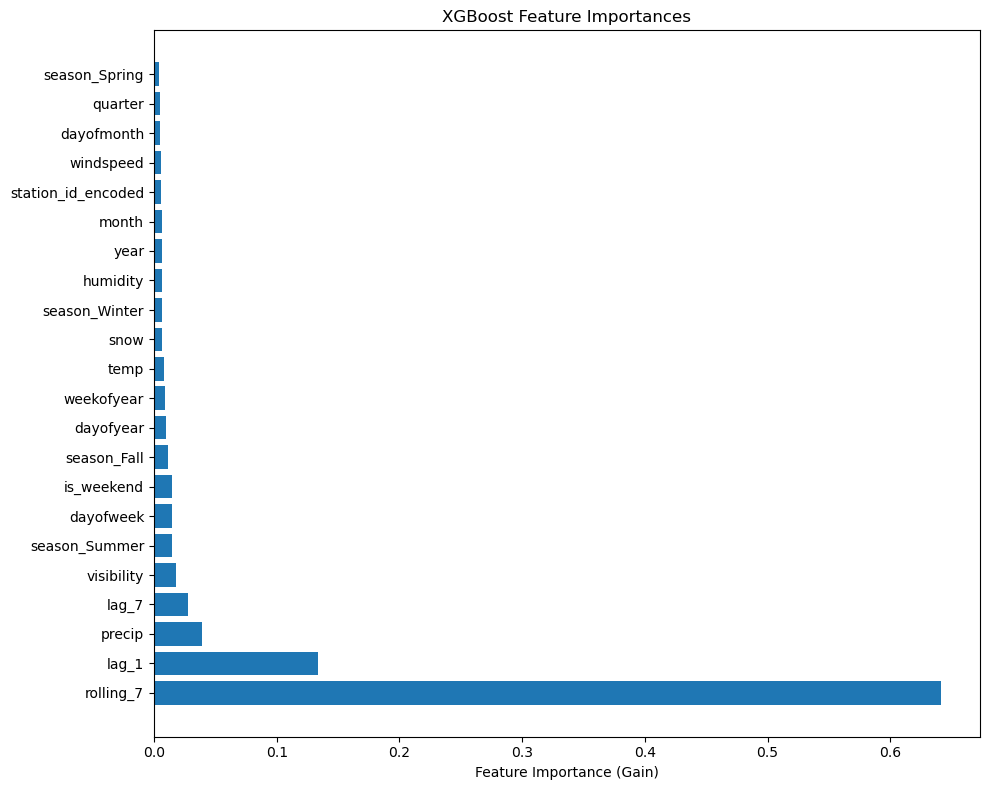

               feature  importance
16           rolling_7    0.641066
14               lag_1    0.133463
2               precip    0.039397
15               lag_7    0.027601
5           visibility    0.017643
19       season_Summer    0.014705
6            dayofweek    0.014566
7           is_weekend    0.014543
17         season_Fall    0.011076
11           dayofyear    0.009851
13          weekofyear    0.009073
0                 temp    0.008360
3                 snow    0.006669
20       season_Winter    0.006635
1             humidity    0.006555
9                 year    0.006545
10               month    0.006329
21  station_id_encoded    0.005836
4            windspeed    0.005716
12          dayofmonth    0.005173
8              quarter    0.004701
18       season_Spring    0.004501


In [71]:
model = xgb_grid_search.best_estimator_  

# Get feature importances
importances = model.feature_importances_

# Match to feature names
feature_names = X_train.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance',ascending=False)

# plotting it
plt.figure(figsize=(10, 8))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel("Feature Importance (Gain)")
plt.title("XGBoost Feature Importances")
plt.tight_layout()
plt.show()
print(importance_df)


#### Interpretation of XGBoost Feature Importances

The model's internal feature importance ranking confirms that recent activity is the strongest predictor of daily bike demand:



- **`rolling_7`** (7-day rolling average) is by far the most important feature, contributing over 64% of the total gain,the average improvement in the model’s loss function when a feature is used to split a node. This suggests strong weekly patterns in usage.
- **`lag_1`** and **`lag_7`** also rank highly, capturing short- and long-term temporal dependencies.
- **Weather features** like `precip` and `visibility` contribute meaningfully but much less than lag features.
- **Calendar features** (`dayofweek`, `is_weekend`, `season`) show impact, indicating that while time of week and seasonality affect demand, they’re secondary to usage history.
- **Station ID encoding** has low importance, suggesting the model generalizes well across stations rather than overfitting to specific ones.

Overall, the model relies primarily on recent trip patterns, with weather and calendar signals providing useful context.

In [72]:
explainer = shap.TreeExplainer(xgb_grid_search.best_estimator_)
shap_values = explainer.shap_values(X_train)

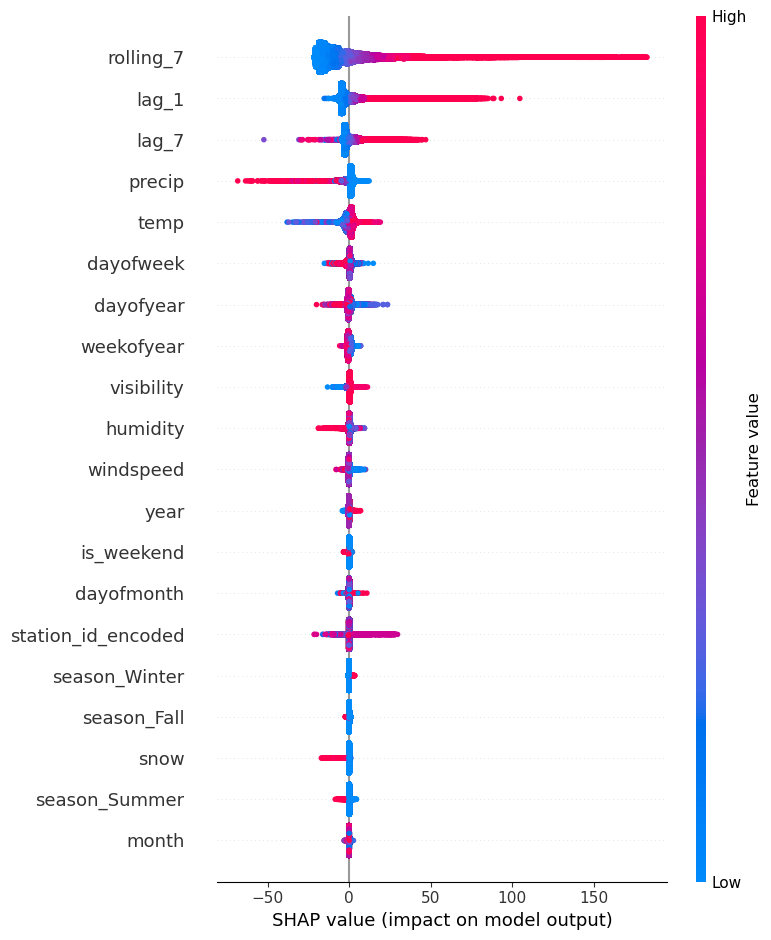

In [73]:
shap.summary_plot(shap_values, X_train)